In [2]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F


sys.path.append('../..')
import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter

### 0 Loading Data

In [13]:
future_index= 'ic'
params = {
    "batch_size": 32,
    "hidden_size": 64,
    "seq_length": 8,
    "weight_decay": 0.03699014272607559,
    "num_layers": 8,
    "learning_rate": 0.001264079267383521,
#     "learning_rate": 0.0006264079267383521,
    "dropout_prob": 0.0049846528896436
#     "dropout_prob": 0.2149846528896436
}

In [4]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

### 1 Define LSTM Model

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device, directions=1):
        super(LSTM, self).__init__()

        self.name = 'LSTM'
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions
        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return torch.zeros(state_dim).to(self.device), torch.zeros(state_dim).to(self.device)

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x[:, -1, :], (h, c)

In [6]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])
        states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            states = [state.detach() for state in states]
            y_pred, states = model(x_batch, states)

            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {model.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
    plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [7]:
def train(train_data_loader, model, criterion, optimizer, params):
    glog.info(f"Start Training Model")

    # Set to train mode
    model.train()
    training_states = model.init_hidden_states(params['batch_size'])
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        # Truncated Backpropagation
        training_states = [state.detach() for state in training_states]
        # Make prediction
        y_pred, training_states = model(x_batch, training_states)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    glog.info(f"End Training Model")

    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [8]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        val_states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            val_states = [state.detach() for state in val_states]
            y_pred, val_states = model(x_batch, val_states)

            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [10]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [ ]:

# create model instance
model = LSTM(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    output_size=xfinai_config.lstm_model_config['output_size'],
    dropout_prob=params['dropout_prob'],
    device=device
).to(device)

criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = 100

print(model)
train_losses = []
val_losses = []
# train the model
for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
    train_losses.append(train_score)
    val_losses.append(val_score)

I0313 10:41:13.834991 6684 2394707304.py:2] Start Training Model


LSTM(
  (lstm): LSTM(28, 64, num_layers=8, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


I0313 10:41:40.582182 6684 2394707304.py:30] End Training Model
I0313 10:41:51.161004 6684 2394707304.py:2] Start Training Model


Epoch :0 train_score 32540514.13157895 val_score 1377826.2900717703


I0313 10:41:59.326526 6684 2394707304.py:30] End Training Model
I0313 10:42:02.761271 6684 2394707304.py:2] Start Training Model


Epoch :1 train_score 50856.685623819176 val_score 10808.402155187141


I0313 10:42:08.706426 6684 2394707304.py:30] End Training Model
I0313 10:42:11.893412 6684 2394707304.py:2] Start Training Model


Epoch :2 train_score 3507.6163294988387 val_score 7270.005010928834


I0313 10:42:17.637412 6684 2394707304.py:30] End Training Model
I0313 10:42:20.802414 6684 2394707304.py:2] Start Training Model


Epoch :3 train_score 1743.373752897436 val_score 9543.616985412305


I0313 10:42:26.152718 6684 2394707304.py:30] End Training Model
I0313 10:42:28.836050 6684 2394707304.py:2] Start Training Model


Epoch :4 train_score 1745.2831242164357 val_score 8634.049826448614


I0313 10:42:33.646412 6684 2394707304.py:30] End Training Model
I0313 10:42:36.284339 6684 2394707304.py:2] Start Training Model


Epoch :5 train_score 2640.836459661785 val_score 7082.3667628502735


I0313 10:42:41.117762 6684 2394707304.py:30] End Training Model
I0313 10:42:43.719588 6684 2394707304.py:2] Start Training Model


Epoch :6 train_score 2208.918769042458 val_score 4405.347218990326


I0313 10:42:48.560688 6684 2394707304.py:30] End Training Model
I0313 10:42:51.161674 6684 2394707304.py:2] Start Training Model


Epoch :7 train_score 1907.165329018278 val_score 11618.526111000463


I0313 10:42:55.993657 6684 2394707304.py:30] End Training Model
I0313 10:42:58.603765 6684 2394707304.py:2] Start Training Model


Epoch :8 train_score 1684.199620598241 val_score 12695.13846605018


I0313 10:43:03.431916 6684 2394707304.py:30] End Training Model
I0313 10:43:06.108108 6684 2394707304.py:2] Start Training Model


Epoch :9 train_score 3412.313999413303 val_score 7488.9099056937475


I0313 10:43:11.337193 6684 2394707304.py:30] End Training Model
I0313 10:43:14.302268 6684 2394707304.py:2] Start Training Model


Epoch :10 train_score 1712.496618261748 val_score 14233.361484299436


I0313 10:43:19.814203 6684 2394707304.py:30] End Training Model
I0313 10:43:23.114609 6684 2394707304.py:2] Start Training Model


Epoch :11 train_score 3877.371995350961 val_score 13069.23483255149


I0313 10:43:29.096937 6684 2394707304.py:30] End Training Model
I0313 10:43:32.066880 6684 2394707304.py:2] Start Training Model


Epoch :12 train_score 3107.096724277478 val_score 11384.387071490859


I0313 10:43:37.368615 6684 2394707304.py:30] End Training Model
I0313 10:43:40.017973 6684 2394707304.py:2] Start Training Model


Epoch :13 train_score 2384.34538306688 val_score 6528.829596405394


I0313 10:43:44.873918 6684 2394707304.py:30] End Training Model
I0313 10:43:47.503293 6684 2394707304.py:2] Start Training Model


Epoch :14 train_score 2184.114811965723 val_score 20469.113115484066


I0313 10:43:52.325722 6684 2394707304.py:30] End Training Model
I0313 10:43:54.935175 6684 2394707304.py:2] Start Training Model


Epoch :15 train_score 2984.521860706749 val_score 8801.782131491665


I0313 10:43:59.764321 6684 2394707304.py:30] End Training Model
I0313 10:44:02.400415 6684 2394707304.py:2] Start Training Model


Epoch :16 train_score 2631.425855470046 val_score 18946.23682595212


I0313 10:44:07.279492 6684 2394707304.py:30] End Training Model
I0313 10:44:09.909074 6684 2394707304.py:2] Start Training Model


Epoch :17 train_score 3104.300545975352 val_score 16571.779106724207


I0313 10:44:15.090124 6684 2394707304.py:30] End Training Model
I0313 10:44:17.991696 6684 2394707304.py:2] Start Training Model


Epoch :18 train_score 2893.494147312128 val_score 11522.141559071519


I0313 10:44:22.923911 6684 2394707304.py:30] End Training Model
I0313 10:44:25.665811 6684 2394707304.py:2] Start Training Model


Epoch :19 train_score 2586.497983667839 val_score 14950.832242445513


I0313 10:44:30.955565 6684 2394707304.py:30] End Training Model
I0313 10:44:33.661365 6684 2394707304.py:2] Start Training Model


Epoch :20 train_score 3455.0053512856152 val_score 10910.749735051935


I0313 10:44:38.853062 6684 2394707304.py:30] End Training Model
I0313 10:44:41.698073 6684 2394707304.py:2] Start Training Model


Epoch :21 train_score 1522.987821312042 val_score 12158.170897543145


I0313 10:44:46.915035 6684 2394707304.py:30] End Training Model
I0313 10:44:49.651233 6684 2394707304.py:2] Start Training Model


Epoch :22 train_score 3593.468708412499 val_score 7252.945364874516


I0313 10:44:54.707959 6684 2394707304.py:30] End Training Model
I0313 10:44:57.406302 6684 2394707304.py:2] Start Training Model


Epoch :23 train_score 1708.0435191889128 val_score 14040.172087053363


I0313 10:45:02.308585 6684 2394707304.py:30] End Training Model
I0313 10:45:04.958255 6684 2394707304.py:2] Start Training Model


Epoch :24 train_score 3897.3376988315126 val_score 12887.557390030492


I0313 10:45:10.213759 6684 2394707304.py:30] End Training Model
I0313 10:45:13.006645 6684 2394707304.py:2] Start Training Model


Epoch :25 train_score 4440.783401575955 val_score 12518.969156240162


I0313 10:45:18.015901 6684 2394707304.py:30] End Training Model
I0313 10:45:20.888389 6684 2394707304.py:2] Start Training Model


Epoch :26 train_score 1702.9847280146403 val_score 11999.869497801128


I0313 10:45:25.998730 6684 2394707304.py:30] End Training Model
I0313 10:45:29.015460 6684 2394707304.py:2] Start Training Model


Epoch :27 train_score 2390.9848120383667 val_score 20344.00655268254


I0313 10:45:34.621619 6684 2394707304.py:30] End Training Model
I0313 10:45:37.639014 6684 2394707304.py:2] Start Training Model


Epoch :28 train_score 2924.8462726282733 val_score 8733.20700633583


I0313 10:45:42.968495 6684 2394707304.py:30] End Training Model
I0313 10:45:45.864914 6684 2394707304.py:2] Start Training Model


Epoch :29 train_score 2837.2378311316934 val_score 3256.715895556947


I0313 10:45:50.768099 6684 2394707304.py:30] End Training Model
I0313 10:45:53.406887 6684 2394707304.py:2] Start Training Model


Epoch :30 train_score 2804.4465407184434 val_score 16215.27758051676


I0313 10:45:58.301248 6684 2394707304.py:30] End Training Model
I0313 10:46:01.021545 6684 2394707304.py:2] Start Training Model


Epoch :31 train_score 4837.964114686519 val_score 12767.975625923376


I0313 10:46:06.028136 6684 2394707304.py:30] End Training Model
I0313 10:46:08.795810 6684 2394707304.py:2] Start Training Model


Epoch :32 train_score 3544.0247456126235 val_score 6234.13442438299


I0313 10:46:13.818230 6684 2394707304.py:30] End Training Model
I0313 10:46:16.827978 6684 2394707304.py:2] Start Training Model


Epoch :33 train_score 2594.1109319531747 val_score 10463.439917678468


I0313 10:46:22.256497 6684 2394707304.py:30] End Training Model
I0313 10:46:25.256951 6684 2394707304.py:2] Start Training Model


Epoch :34 train_score 1947.2986920575777 val_score 11622.242389605946


I0313 10:46:30.815179 6684 2394707304.py:30] End Training Model
I0313 10:46:34.457417 6684 2394707304.py:2] Start Training Model


Epoch :35 train_score 3845.3421187606154 val_score 14429.623543041174


I0313 10:46:41.046348 6684 2394707304.py:30] End Training Model
I0313 10:46:44.221097 6684 2394707304.py:2] Start Training Model


Epoch :36 train_score 3223.637623494892 val_score 4137.012060110649


I0313 10:46:50.310233 6684 2394707304.py:30] End Training Model
I0313 10:46:53.124848 6684 2394707304.py:2] Start Training Model


Epoch :37 train_score 2102.824102465616 val_score 12474.485846451025


I0313 10:46:58.338784 6684 2394707304.py:30] End Training Model
I0313 10:47:01.102768 6684 2394707304.py:2] Start Training Model


Epoch :38 train_score 2876.099487672012 val_score 19819.425028276215


I0313 10:47:06.094923 6684 2394707304.py:30] End Training Model
I0313 10:47:08.932186 6684 2394707304.py:2] Start Training Model


Epoch :39 train_score 3475.9098343917626 val_score 6924.1506575967705


I0313 10:47:13.930953 6684 2394707304.py:30] End Training Model
I0313 10:47:16.623508 6684 2394707304.py:2] Start Training Model


Epoch :40 train_score 2497.4893325732655 val_score 18430.236196527072


I0313 10:47:21.518759 6684 2394707304.py:30] End Training Model
I0313 10:47:24.128551 6684 2394707304.py:2] Start Training Model


Epoch :41 train_score 2945.1562881743507 val_score 8200.838371235788


I0313 10:47:28.950272 6684 2394707304.py:30] End Training Model
I0313 10:47:31.767294 6684 2394707304.py:2] Start Training Model


Epoch :42 train_score 3274.6697223608576 val_score 13477.72973675705


I0313 10:47:37.015072 6684 2394707304.py:30] End Training Model
I0313 10:47:39.787052 6684 2394707304.py:2] Start Training Model


Epoch :43 train_score 2239.661095509689 val_score 4498.13963956696


I0313 10:47:45.223569 6684 2394707304.py:30] End Training Model
I0313 10:47:48.285022 6684 2394707304.py:2] Start Training Model


Epoch :44 train_score 2392.4491541191724 val_score 11561.605950058933


I0313 10:47:53.610973 6684 2394707304.py:30] End Training Model
I0313 10:47:56.511839 6684 2394707304.py:2] Start Training Model


Epoch :45 train_score 3056.051197065691 val_score 13741.570274827583


I0313 10:48:01.817364 6684 2394707304.py:30] End Training Model
I0313 10:48:04.649712 6684 2394707304.py:2] Start Training Model


Epoch :46 train_score 3627.322207318539 val_score 10594.743775098517


I0313 10:48:09.873506 6684 2394707304.py:30] End Training Model
I0313 10:48:13.264029 6684 2394707304.py:2] Start Training Model


Epoch :47 train_score 2718.6093491732217 val_score 6494.746216075842


I0313 10:48:19.459452 6684 2394707304.py:30] End Training Model
I0313 10:48:22.851438 6684 2394707304.py:2] Start Training Model


Epoch :48 train_score 2334.648160665229 val_score 12708.794383295415


I0313 10:48:29.298259 6684 2394707304.py:30] End Training Model
I0313 10:48:32.294976 6684 2394707304.py:2] Start Training Model


Epoch :49 train_score 1448.2455491882763 val_score 11817.753616898824


I0313 10:48:37.757449 6684 2394707304.py:30] End Training Model
I0313 10:48:40.797157 6684 2394707304.py:2] Start Training Model


Epoch :50 train_score 1887.1992418982766 val_score 5773.314660159024


I0313 10:48:46.202975 6684 2394707304.py:30] End Training Model
I0313 10:48:49.147450 6684 2394707304.py:2] Start Training Model


Epoch :51 train_score 2242.2006931761234 val_score 15325.04189797908


I0313 10:48:54.323859 6684 2394707304.py:30] End Training Model
I0313 10:48:57.193199 6684 2394707304.py:2] Start Training Model


Epoch :52 train_score 2950.6135499580055 val_score 8726.362109184265


I0313 10:49:02.459184 6684 2394707304.py:30] End Training Model


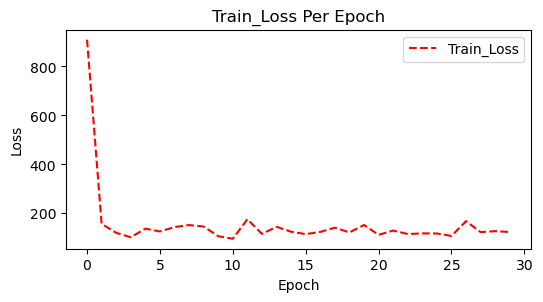

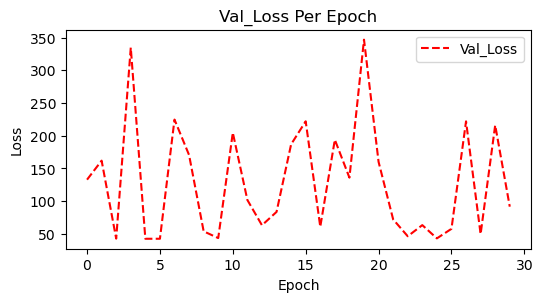

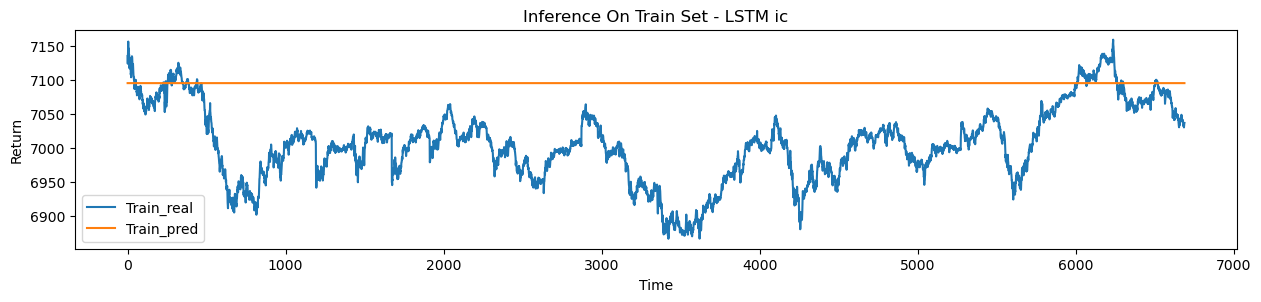

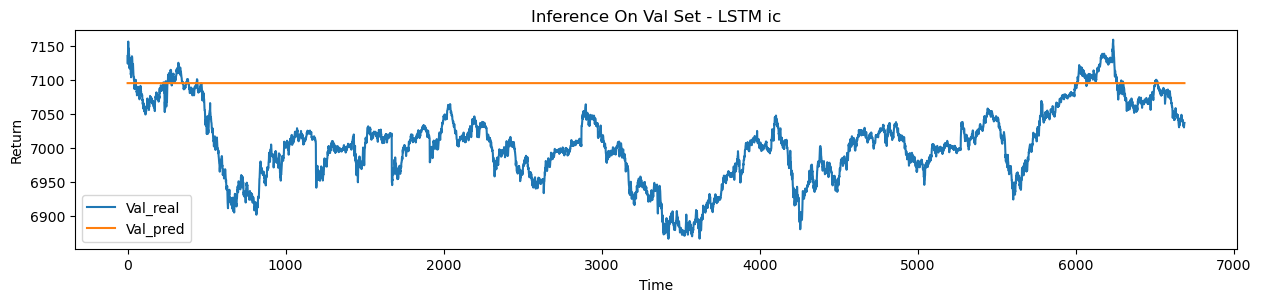

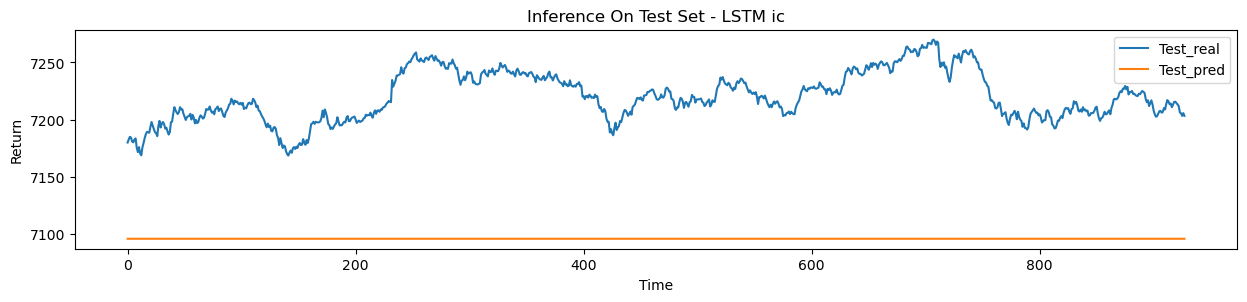

In [12]:
# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)